# Задача прогнозирования оттока клиентов телеком-оператора

## Описание проекта :

Вам предоставляется отчет и набор данных от телекоммуникационной компании. Данные содержат информацию о более чем трех тысячах пользователей, их демографических характеристиках, услугах, которыми они пользуются, длительности использования услуг оператора и сумме оплаты.

Задача - проанализировать данные и спрогнозировать отток пользователей (выявить людей, которые будут и не будут продлевать свой контракт). Удержание пользователей - одна из наиболее актуальных задач в областях, где распространение услуги составляет порядка 100%. Ярким примером такой области является сфера телекома. Удержание клиента обойдется компании дешевле, чем привлечение нового.

Прогнозируя отток, мы можем вовремя среагировать и постараться удержать клиента, который хочет уйти. На основании данных об услугах, которыми пользуется клиент, мы можем сделать ему специальное предложение, пытаясь изменить его решение покинуть оператора. Это сделает задачу удержания проще в реализации, чем задачу привлечения новых пользователей. На основе полученных данных команда DS проверяет возможно и эффективно ли строить и применять модель оттока. В положительном случае модель обучается, проводится A/B тест. Если результаты A/B теста экономически и статистически значимы, то принимается решение о внедрении модели в продакшн. Команде разработки даётся задание подготовить соответствующий функционал в приложении, а также автоматическую рассылку на почту и телефон. После этого выбирается периодичность с которой будет производится анализ на предмет оттока. В результате этого на серверах компании появляется соответствующая информация. Далее, в соотвествии с ожидаемым оттоком, клиенты получают информацию об акции/скидке и других предложениях. Позже комадна DS проверяет результаты A/B теста.

## Бизнес - цель :

Цель - уменьшить количество уходящих клиентов.

Критерий успеха - получить положительное статистически и экономически значимое уменьшение оттока относительно прошлого периода (в %).

## Математическая задача :

Для достижения цели будем решать задачу бинарной классификации: отток/не отток.

В качестве базовой модели будем использовать Random Forest Classifier.
Разработанная модель прогнозирования позволит находить клиентов, склонных к оттоку по их поведению и для проведения последующих мероприятий, связанных с удержанием клиентов.
Т.к. классы не сбалансированы, будем использовать метрику ROC-AUC.

## Набор данных :

Набор [данных](https://bigml.com/user/francisco/gallery/dataset/5163ad540c0b5e5b22000383) телеком компании.


Датасет содержит следующие поля :
- State (Код штата) 
- Account length (Срок обслуживания клиента компанией)
- Area code (Префикс номера телефона)
- International plan (Подключен ли международный роуминг)
- Voice mail plan (Подключена ли международная почта)
- Number vmail messages (Количество голосовых сообщений)
- Total day minutes (Суммарная длительность разговоров днём)
- Total day calls (Количество звонков днём)
- Total day charge (Сумма оплаты за услуги днём)
- Total eve minutes (Суммарная длительность разговоров вечером)
- Total eve calls (Количество звонков вечером)
- Total eve charge (Сумма оплаты за услуги вечером)
- Total night minutes (Суммарная длительность разговоров ночью)
- Total night calls (Количество звонков ночью)
- Total night charge (Сумма оплаты за услуги ночью)
- Total intl minutes (Суммарная длительность международных разговоров)
- Total intl calls (Количество международных звонков )
- Total intl charge (Сумма оплаты за международные разговоры)
- Customer service calls (Число обращений в сервисный центр)
- Churn (Отток) - целевая переменная

## Валидация данных и оценка потенциала модели :

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Визуализируем данные :


In [2]:
url = 'https://drive.google.com/file/d/1_gvIy2MoOTeX4oEk8xaa_1Wo1wwnEjS-/view?usp=sharing'
url2 = 'https://drive.google.com/uc?id='+ url.split('/')[-2]
df = pd.read_csv(url2)
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
#посмотрим на размер данных
 
print(df.shape)

(3333, 20)


In [4]:
# посмотрим на информацию о типах данных :
 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

Выделим следующие группы признаков в рассматриваемом датасете :
- бинарные: "International plan", "Voice mail plan"
- категориальные: "State"
- все остальные признаки относятся к количественным 

Произведём преобразования признаков для дальнейшего удобства :

In [5]:
df["Churn"] = df["Churn"].astype("int64")
d = {"No": False, "Yes": True}
df["International plan"] = df["International plan"].map(d)
df["Voice mail plan"] = df["Voice mail plan"].map(d)

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   bool   
 4   Voice mail plan         3333 non-null   bool   
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

Начнём с определения доли оттока в рассматриваемом датасете и визуализируем эту долю :
    

In [7]:
df['Churn'].mean()  

0.14491449144914492

Text(0.5, 1.0, 'Распределение оттока клиентов')

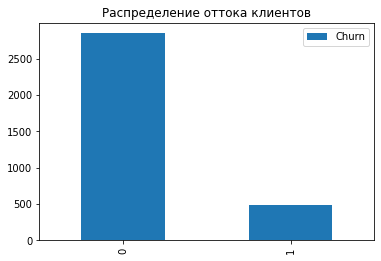

In [8]:
df['Churn'].value_counts().plot(kind='bar', label='Churn')
plt.legend()
plt.title('Распределение оттока клиентов')

14.5% нелояльных пользователей для компании - довольно высокая цифра, построение модели для прогнозирования доли оттока пользователей с целью изучения причин оттока и планирования дальнейших шагов для удержания ЦА в таких кейсах является очень актуальной задачей.

Посмотрим на данные по длительности минут в разное время суток в зависимости от признака "Churn" :
    
    

In [9]:
columns_to_show = ["Total day minutes", "Total eve minutes", "Total night minutes"]

df.groupby(["Churn"])[columns_to_show].describe(percentiles=[])

Total day minutes                         ... Total night minutes               
                  count        mean        std  ...                 min     50%    max
Churn                                           ...                                   
0                2850.0  175.175754  50.181655  ...                23.2  200.25  395.0
1                 483.0  206.914079  68.997792  ...                47.4  204.80  354.9

[2 rows x 18 columns]

Интересной особенностью задачи является то, что в среднем нелояльные клиенты пользуются связью больше лояльных (нагляднее всего это наблюдается днём)

Построим матрицу корреляций количественных признаков :

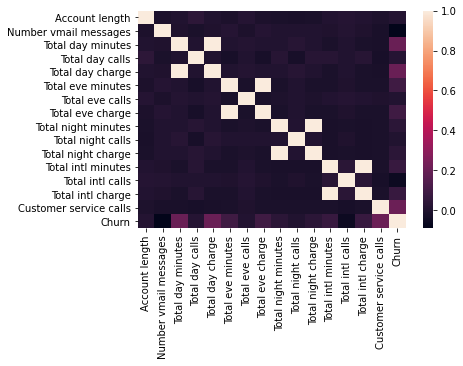

In [10]:
corr_matrix = df.drop(['State', 'International plan', 'Voice mail plan',
                      'Area code'], axis=1).corr()
sns.heatmap(corr_matrix)

Учитывая линейную взаимосвязь между признаками "Total day charge" и "Total day minutes" (по вечерним, ночным и международным
звонкам ситуация аналогичная), признаки "Total day minutes", "Total eve minutes", "Total night minutes", "Total intl minutes" 
можно удалить, полезной информации они не несут

Посмотрим теперь на распределения признаков :

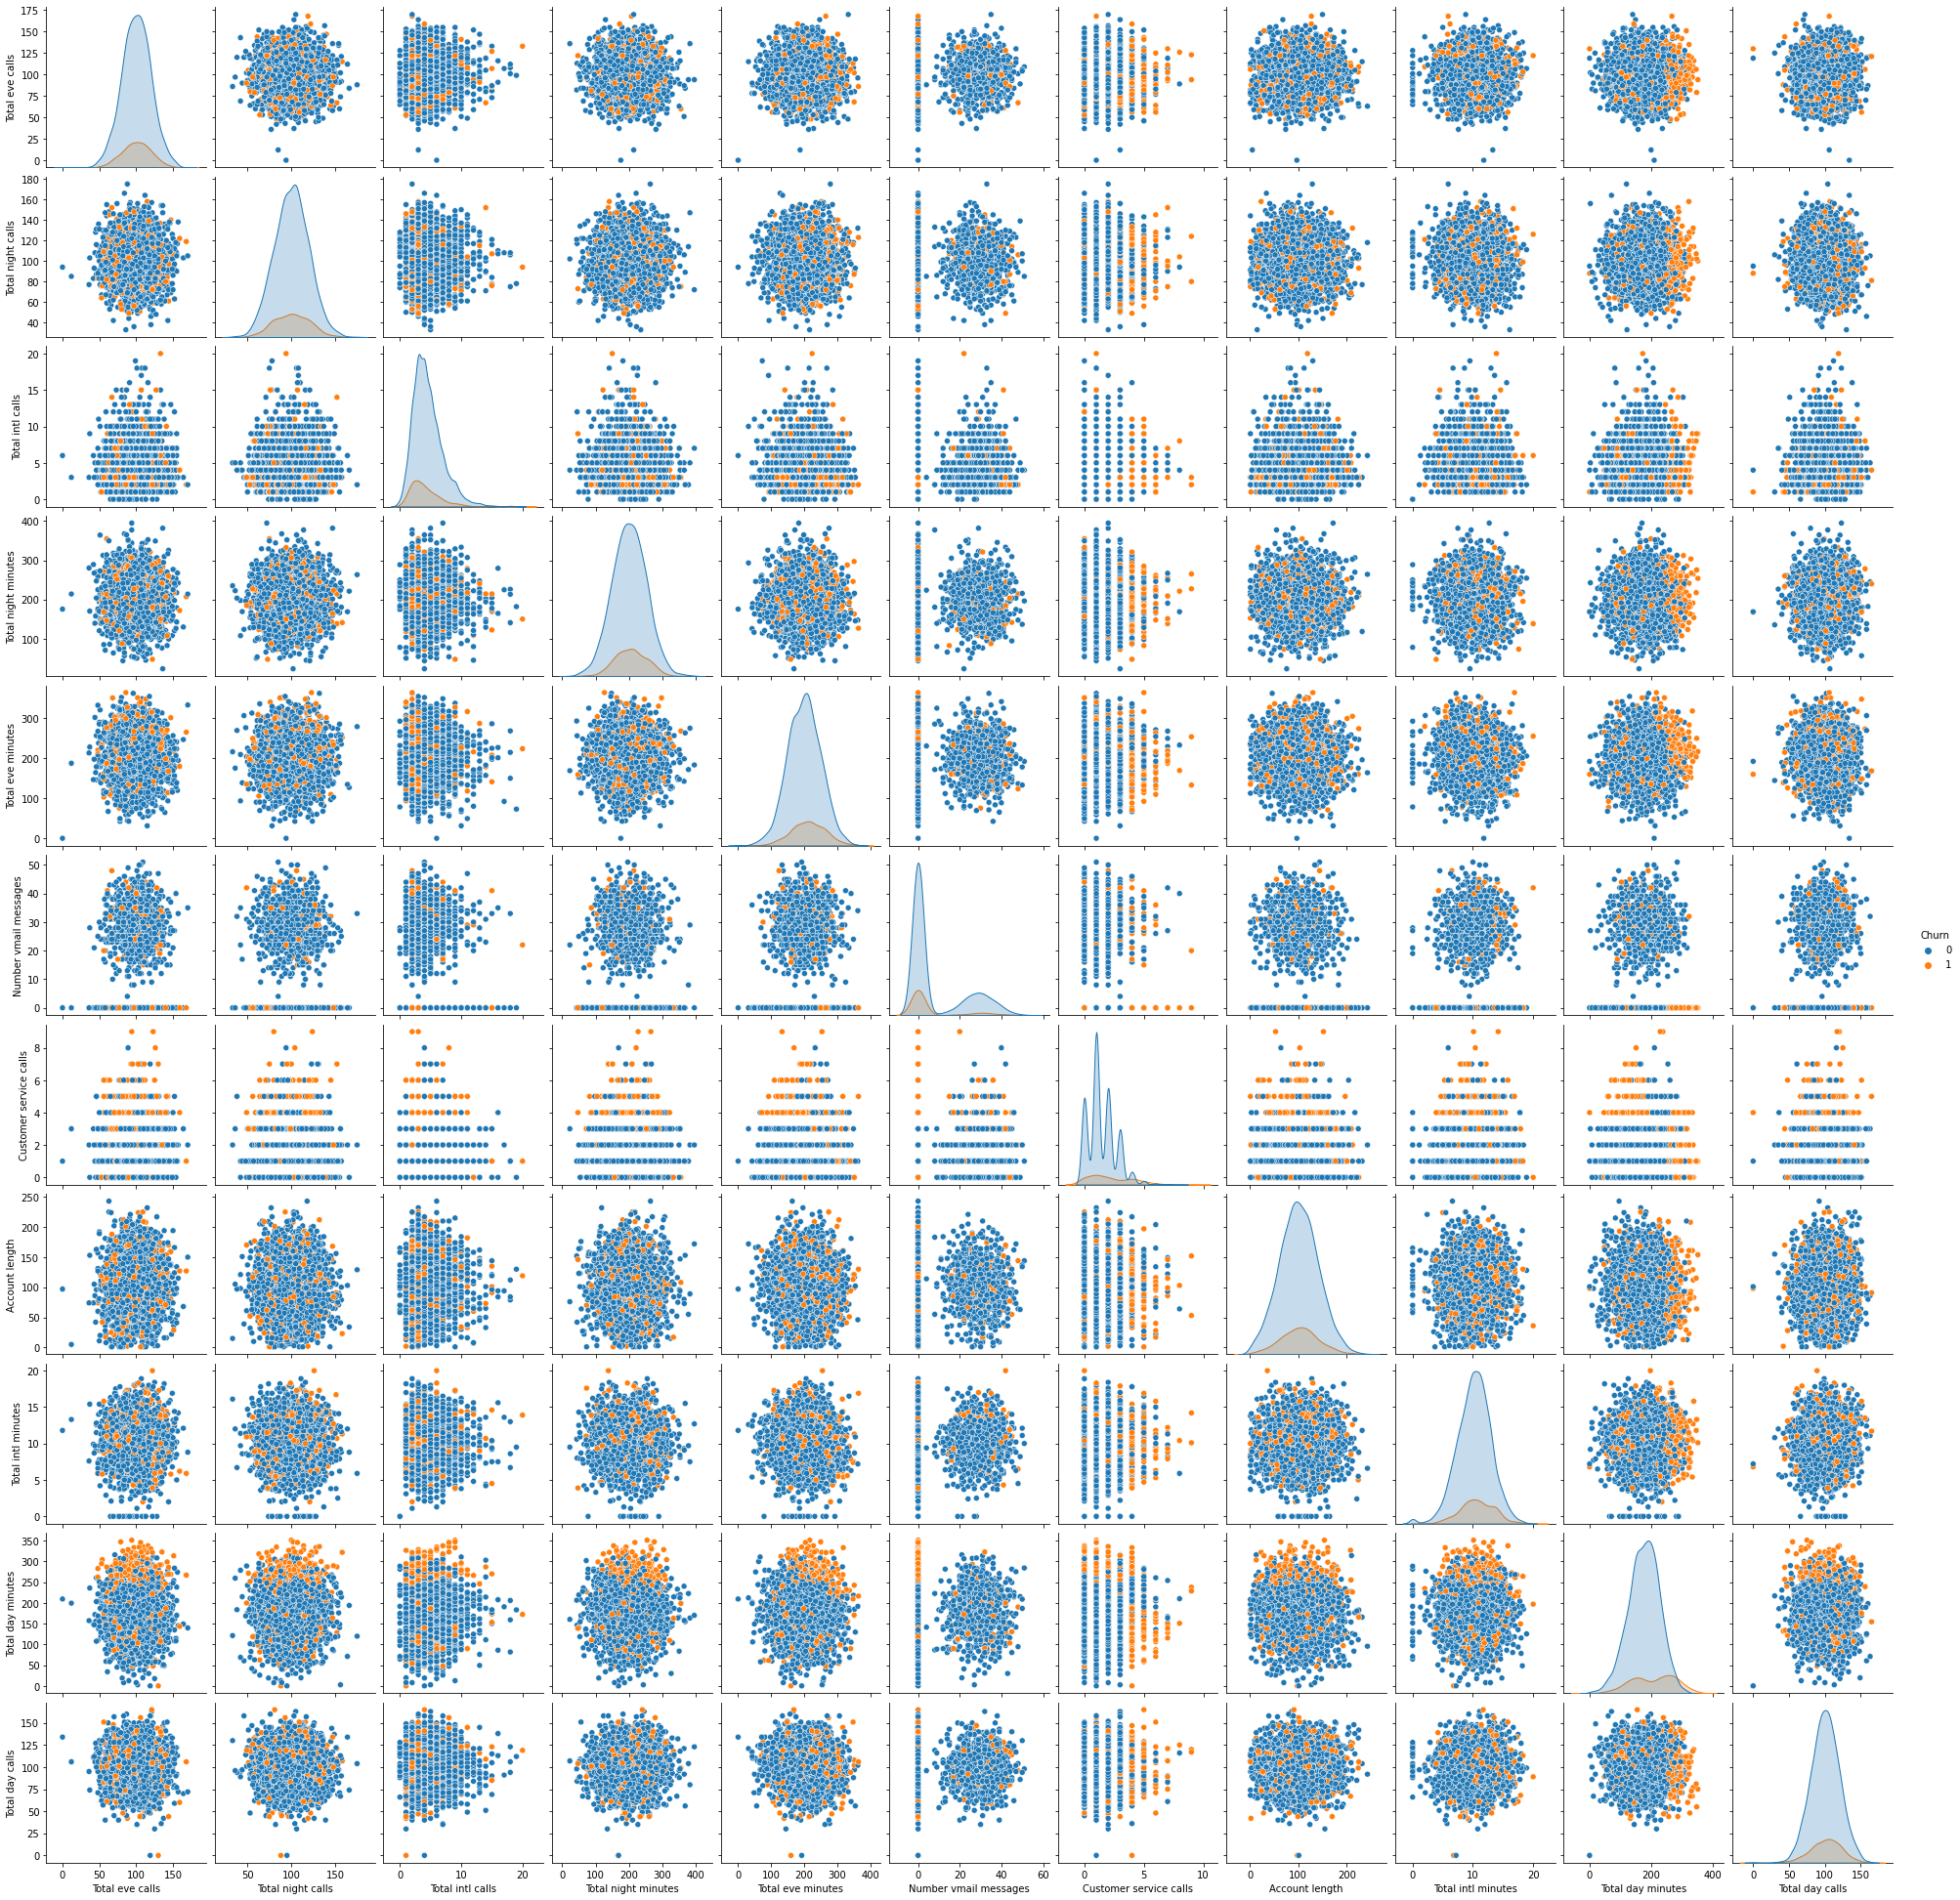

In [11]:
features = list(set(df.columns) - set(['State', 'International plan', 'Voice mail plan',  'Area code',
                                      'Total day charge',   'Total eve charge',   'Total night charge',
                                        'Total intl charge', 'Churn']))
 
sns.pairplot(df[features + ['Churn']], hue='Churn')

Картины попарных распределений признаков говорят о том, что в рассматримаемом датасете существуют такие пары переменных, в которых 
данные становятся достаточно хорошо разделимы нелинейной поверхностью. Таким образом, рассматриваемая задача классификации может быть решена с помощью построения композиции моделей, учитывающих нелинейную взаимосвязь в данных (например, с помощью случайного леса или градиентного бустинга)



### Базовая модель :

В качестве базовый модели возьмем случайный лес, и обучим его два раза на исходной выборке, используя разные параметры. Далее сравним ROC AUC двух обученных моделей (предварительно исключив из выборки штат и все линейно-зависимые признаки, например Total day minutes, Total eve minutes и тд)




In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [140]:
#Обучение случайного леса со стандартными параметрами
#Удаляем из признаков линейно-зависимые и штат
 
y = df['Churn']
X = df.drop(['Churn', 'State','Total day minutes','Total eve minutes','Total night minutes','Total intl minutes'], axis=1)

In [141]:
# Инициализируем случайный лес с параметрами по умолчанию

rfc1 = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

In [142]:
#Разбиваем исходную выборку на тестовую и валидационную

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [143]:
#Обучаем случайный лес и оцениванием качество модели на валидационной выборке

rfc1.fit(X_train, y_train)
pred_proba = rfc1.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.8855941399891482


In [144]:
#Оцениванием качество модели методом кросс-валидации
rfcv1 = RandomForestClassifier(**rfc1.get_params())

cv_scores = cross_val_score(rfcv1, X_test, y_test, scoring='roc_auc', cv=5, n_jobs=-1)
mean_roc_auc = np.mean(cv_scores)
cv_scores = cross_val_score(rfcv1, X_test, y_test, scoring='precision', cv=5, n_jobs=-1)
mean_precision = np.mean(cv_scores)
cv_scores = cross_val_score(rfcv1, X_test, y_test, scoring='recall', cv=5, n_jobs=-1)
mean_recall = np.mean(cv_scores)
print('mean roc_auc', mean_roc_auc)
print('mean precision', mean_precision)
print('mean recall', mean_recall)

mean roc_auc 0.8657686980609418
mean precision 0.8066666666666666
mean recall 0.23578947368421055


In [172]:
y_pred_test1 = rfc1.predict(X_test)

Conf_mat=confusion_matrix(y_test, y_pred_test1)
print("TN", Conf_mat[0][0])
print("FN", Conf_mat[1][0])
print("TP", Conf_mat[1][1])
print("FP", Conf_mat[0][1])

TN 560
FN 39
TP 58
FP 10


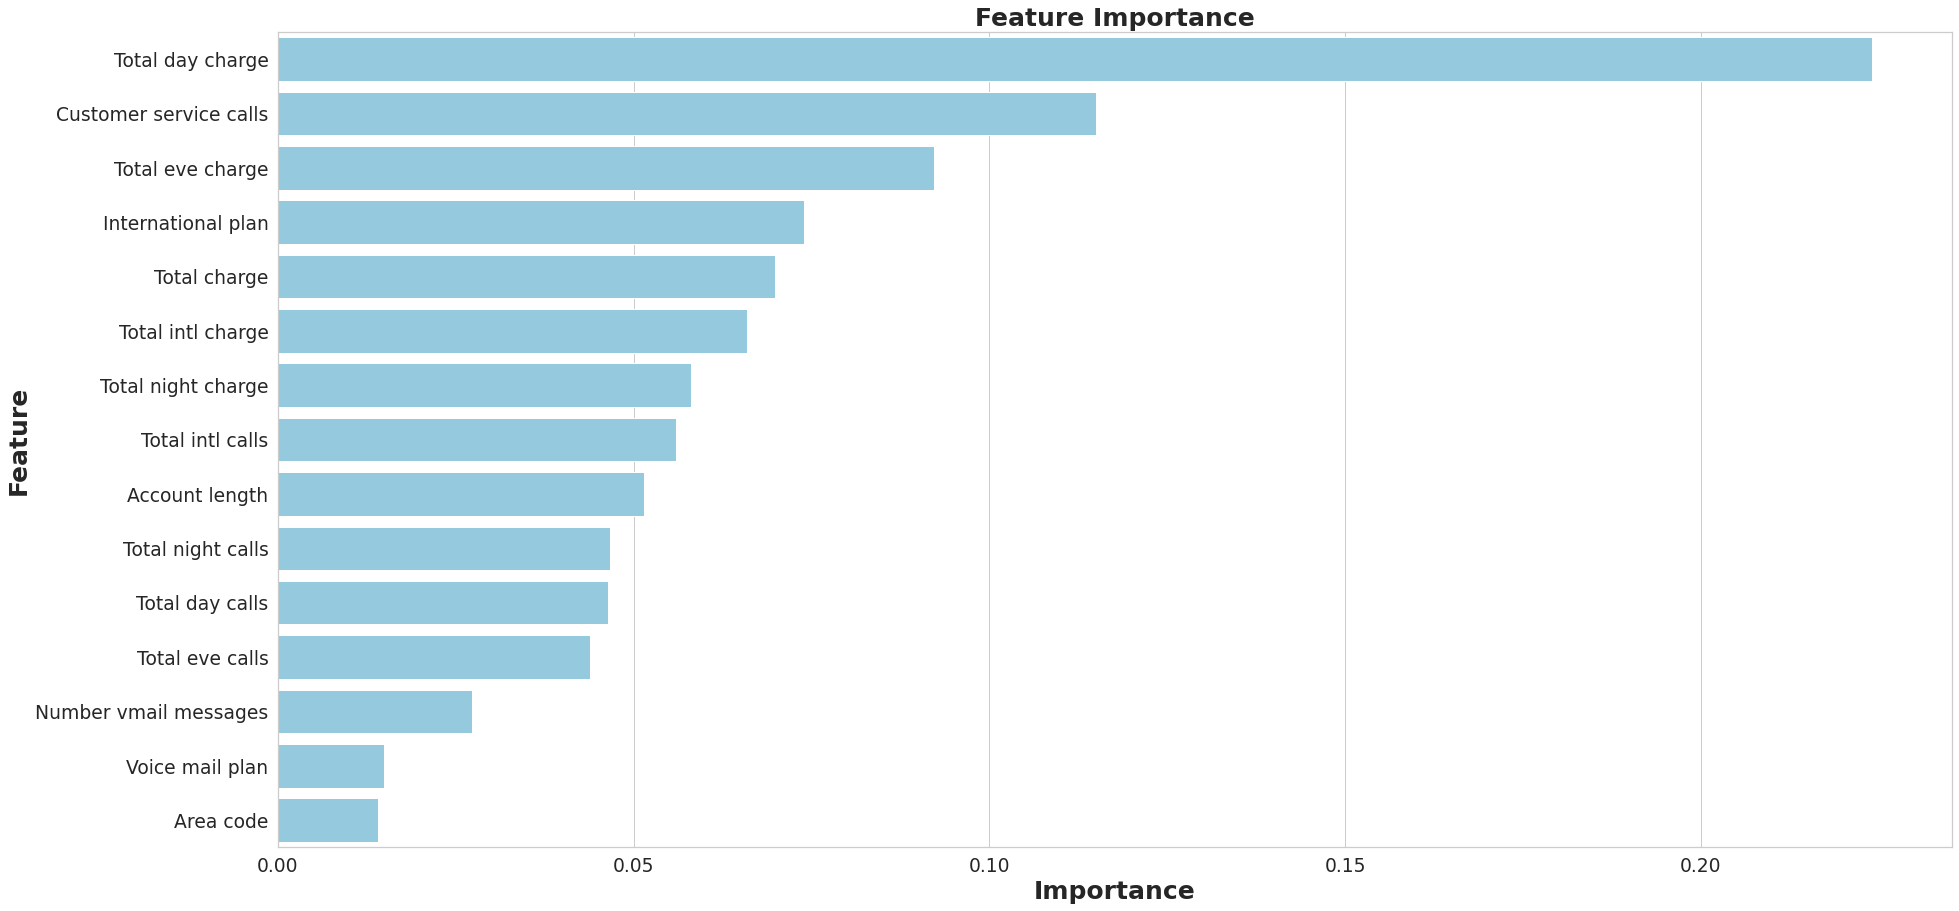

In [102]:
#Важность признаков

rfc_importances = pd.Series(rfc1.feature_importances_)
rfc_features = X.columns
feats = {}

for feature, importance in zip(rfc_features, rfc_importances):
    feats[feature] = importance
rfc_viz = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
rfc_viz = rfc_viz.sort_values(by='Importance', ascending=False)
rfc_viz = rfc_viz.reset_index()
rfc_viz = rfc_viz.rename(columns={'index': 'Feature'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=rfc_viz['Importance'], y=rfc_viz['Feature'], data=rfc_viz, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Feature', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
plt.show()

Рассмотрим теперь случайный лес с другими параметрами : (ограничим параметр глубины деревьев)

In [191]:
rfc2 = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1, max_depth=4,oob_score=True)

In [192]:
rfc2.fit(X_train, y_train)
pred_proba = rfc2.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.8680864532465182


In [193]:
rfcv2 = RandomForestClassifier(**rfc2.get_params())

cv_scores = cross_val_score(rfcv2, X_test, y_test, scoring='roc_auc', cv=5, n_jobs=-1)
mean_roc_auc = np.mean(cv_scores)
cv_scores = cross_val_score(rfcv2, X_test, y_test, scoring='precision', cv=5, n_jobs=-1)
mean_precision = np.mean(cv_scores)
cv_scores = cross_val_score(rfcv2, X_test, y_test, scoring='recall', cv=5, n_jobs=-1)
mean_recall = np.mean(cv_scores)
print('mean roc_auc', mean_roc_auc)
print('mean precision', mean_precision)
print('mean recall', mean_recall)

mean roc_auc 0.838337950138504
mean precision 0.9333333333333332
mean recall 0.07210526315789474


In [194]:
y_pred_test2 = rfc2.predict(X_test)

Conf_mat=confusion_matrix(y_test, y_pred_test2)
print("TN", Conf_mat[0][0])
print("FN", Conf_mat[1][0])
print("TP", Conf_mat[1][1])
print("FP", Conf_mat[0][1])

TN 569
FN 83
TP 14
FP 1


Таким образом, при обучении двух моделей и их проверки на кросс-валидации были получены значения ROC AUC, равные 0.9088 и 0.8990 при использовании стандартных 
параметров и при ограничении максимальной глубины деревьев, соответственно, что является достижением высокого уровня обобщающей способности применяемых аглоритмов машинного обучения. Тем не менее, значения матриц ошибок отличаются существенно, что свидетельствует о 
коренных различиях механизмов прогнозирования оттока у этих моделей. 



#Оценка экономического эффекта 



Посмотрим на изменение экономического эффекта в зависимости от изменения величины ROC AUC, рассчитанной по кросс-валидации :

В рамках задачи наблюдаем падение ROC AUC на $ROC_1 - ROC_2 = 0.9088 - 0.8990 = 0.0098$ при изменении параметров случайного леса. Т.к. экономический эффект в данном случае оценивается следующим образом : $ARPU{\cdot}N{\cdot}p{\cdot}r- C{\cdot}N$, где ARPU - средняя величина прибыли от клиента, N - число клиентов, уходящих в отток по прогнозу модели, p - доля оттока среди удерживаемых, r - вероятность удержания (возмём равным 1) и C - затраты на удержание, тогда :

$${\Delta}S_{eff}=S_1 - S_2$$

$$ S_1 = ARPU{\cdot}N_1{\cdot}p_1- C{\cdot}N_1 = ARPU{\cdot}(TP_1 + FP_1){\cdot}TP_1/(TP_1 + FP_1) - C{\cdot}(TP_1+FP_1)$$

$$ S_2 = ARPU{\cdot}N_2{\cdot}p_2- C{\cdot}N_2 = ARPU{\cdot}(TP_2 + FP_2){\cdot}TP_2/(TP_2 + FP_2) - C{\cdot}(TP_2+FP_2)$$

In [107]:
#Проверим есть ли у нас клиенты, которые не приносят доход

cols = ['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']
df['Total charge'] = df[cols].sum(axis=1) * df['Account length']
df['Total charge'].sort_values().head()

2423    45.42
923     47.75
2879    50.13
2960    51.98
2475    54.47
Name: Total charge, dtype: float64

In [108]:
#Посчитаем средний доход с действующего клиента

ARPU = df[df['Churn']==0]['Total charge'].mean()
print('ARPU =', ARPU)

ARPU = 5891.877115789472


In [109]:
#Будем считать стоимость удержания клиента как 20% от ARPU

C = 0.2 * ARPU
print('С =', C)

С = 1178.3754231578944


In [195]:
def calculate_precision(model, X, y):
  matrix = confusion_matrix(y, model.predict(X))
  return matrix[1][1] / (matrix[1][1] + matrix[0][1])

def calculate_econom_eff(model, X, y, ARPU, C):
  matrix = confusion_matrix(y, model.predict(X))
  return ARPU * matrix[1][1]  - C * (matrix[1][1] + matrix[0][1])

In [196]:
print('precision для первой модели', calculate_precision(rfc1, X_test, y_test))
print('precision для второй модели', calculate_precision(rfc2, X_test, y_test))

precision для первой модели 0.8529411764705882
precision для второй модели 0.9333333333333333


In [197]:
print('экономический эффект от первой модели', calculate_econom_eff(rfc1, X_test, y_test, ARPU, C))
print('экономический эффект от второй модели', calculate_econom_eff(rfc2, X_test, y_test, ARPU, C))

экономический эффект от первой модели 261599.34394105256
экономический эффект от второй модели 64810.648273684186
